Welcome to the 30-minute Flower federated learning tutorial!

In this tutorial you will implement your first Federated Learning project using [Flower](https://flower.ai/).

> You can find a similar tutorial, but using the preferred `flwr run` CLI command to launch your experiments in [the Flower Documentation](https://flower.ai/docs/framework/tutorial-quickstart-pytorch.html). Running Flower from the CLI is recommended. Not all Flower features are available when skipping `flwr run` and when using the Pythonic entrypoint of the Simulation Runtime (i.e. calling directly [run_simulation](https://flower.ai/docs/framework/ref-api/flwr.simulation.run_simulation.html)).

🧑‍🏫 This tutorial starts at zero and expects no familiarity with federated learning. Only a basic understanding of data science and Python programming is assumed. A minimal understanding of ML is not required but if you already know about it, nothing is stopping your from modifying this code as you see fit!

> [Star Flower on GitHub](https://github.com/adap/flower) ⭐️ and join the Flower community on Flower Discuss and the Flower Slack to connect, ask questions, and get help:
> - [Join Flower Discuss](https://discuss.flower.ai/) We'd love to hear from you in the `Introduction` topic! If anything is unclear, post in `Flower Help - Beginners`.
> - [Join Flower Slack](https://flower.ai/join-slack) We'd love to hear from you in the `#introductions` channel! If anything is unclear, head over to the `#questions` channel.

Let's get started!

# Environment Setup

Now let's really begin with this tutorial!

To start working with Flower, very little is required once you have activated your Python environment (e.g. via `conda`, `virtualenv`, `pyenv`, etc). If you are running this code on Colab, there is really nothing to do except to install Flower and other dependencies. The steps below have been verified to run in Colab. Let's first, install Flower, then the ML framework of your choice and extra dependencies you might want to use.

## Installing Flower

You can install flower very conveniently from `pip`:

In [ ]:
!pip install -q "flwr[simulation]" flwr-datasets

We will be using the _simulation_ engine in Flower, which allows you to run a large number of clients without the overheads of manually managing devices. This is achieved via the `Simulation Engine`, the core component in Flower to run simulations efficiently.

## Install your ML framework

Flower is agnostic to your choice of ML Framework. Flower works with `PyTorch`, `Tensorflow`, `NumPy`, `🤗 Transformers`, `MLX`, `JAX`, `scikit-learn`, `fastai`, `Pandas`. Flower also supports all major platforms: `iOS`, `Android` and plain `C++`. You can find a _quickstart- example for each of the above in the [Flower Repository](https://github.com/adap/flower/tree/main/examples) inside the `examples/` directory. And check the [Flower Documentation](https://flower.ai/docs/) for even more learning materials.

In this tutorial we are going to use PyTorch, uncomment the line below if you haven't installed PyTorch in your system. In this tutorial we'll use a small model so using CPU only training will suffice.

In [53]:
# you might see a warning after running the command below, this can be ignored
# if you are running this outside Colab, you probably need to adjust the command below
#!pip install torch==2.8.0 torchvision==0.23.0 --index-url https://download.pytorch.org/whl/cpu

We are going to install some other dependencies you are likely familiar with. We'll use these to make plots.

In [ ]:
!pip install matplotlib

# Centralised training: the old way of doing ML

Let's begin by creating a simple (but complete) training loop as it is commonly done in centralised setups. Starting our tutorial in this way will allow us to very clearly identify which parts of a typical ML pipeline are common to both centralised and federated training and which ones are poles a part.

For this tutorial we'll design a image classification pipeline for [MNIST digits](https://en.wikipedia.org/wiki/MNIST_database) and using a simple CNN model as the network to train. The MNIST dataset is comprised of `28x28` greyscale images with digits from 0 to 9 (i.e. 10 classes in total)


## A dataset

Let's begin by constructing the dataset. We will use 🤗HuggingFace Datasets to download MNIST. We will prepare a function that will be use later to apply standard normalization transformations from `TorchVision` and create the dataloaders for the `train` and `test` partitions.

In [55]:
# we naturally first need to import torch and torchvision
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose
from datasets import load_dataset


def get_mnist_dataloaders(mnist_dataset, batch_size: int):
    pytorch_transforms = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])

    # Prepare transformation functions
    def apply_transforms(batch):
        batch["image"] = [pytorch_transforms(img) for img in batch["image"]]
        return batch

    mnist_train = mnist_dataset["train"].with_transform(apply_transforms)
    mnist_test = mnist_dataset["test"].with_transform(apply_transforms)

    # Construct PyTorch dataloaders
    trainloader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(mnist_test, batch_size=batch_size)
    return trainloader, testloader


# Download dataset
mnist = load_dataset("ylecun/mnist")

We can have a quick overview of our datasets by just typing the object on the command line. For instance, below you can see the sizes of both the `train` and `test` partitions

In [56]:
mnist

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

Let's create a more insightful visualisation. First let's see the distribution over the labels by constructing a histogram. Then, let's visualise some training examples !

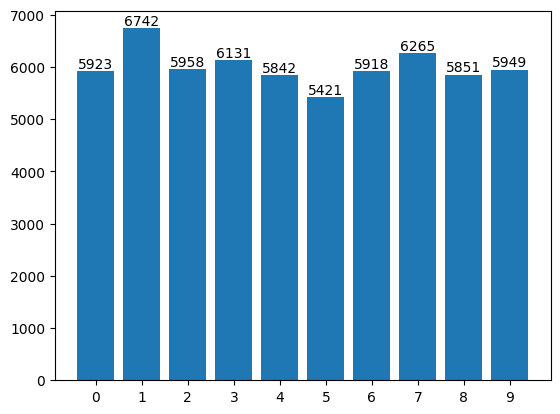

In [57]:
import matplotlib.pyplot as plt
from collections import Counter


# construct histogram
all_labels = mnist["train"]["label"]
all_label_counts = Counter(all_labels)

# visualise histogram
bar = plt.bar(all_label_counts.keys(), all_label_counts.values())
_ = plt.bar_label(bar)

# plot formatting
_ = plt.xticks([label for label in all_label_counts.keys()])

Let's visualise 32 images from the dataset


In [58]:
import random
import numpy as np
from PIL import Image
import io


def visualise_n_random_examples(trainset_, n: int, verbose: bool = True):
    trainset_data = [
        Image.open(io.BytesIO(entry[0].as_py())) for entry in trainset_.data[0]
    ]
    idx = list(range(len(trainset_data)))
    random.shuffle(idx)
    idx = idx[:n]
    if verbose:
        print(f"will display images with idx: {idx}")

    # construct canvas
    num_cols = 8
    num_rows = int(np.ceil(len(idx) / num_cols))
    fig, axs = plt.subplots(figsize=(16, num_rows * 2), nrows=num_rows, ncols=num_cols)

    # display images on canvas
    for c_i, i in enumerate(idx):
        axs.flat[c_i].imshow(trainset_data[i], cmap="gray")

will display images with idx: [14612, 48576, 57689, 59339, 54355, 24756, 22235, 6830, 58065, 25742, 52494, 388, 32615, 30272, 49722, 44675, 51120, 46793, 13964, 34529, 10022, 19947, 26130, 2232, 5508, 49020, 39481, 29315, 47454, 35677, 43582, 58365]


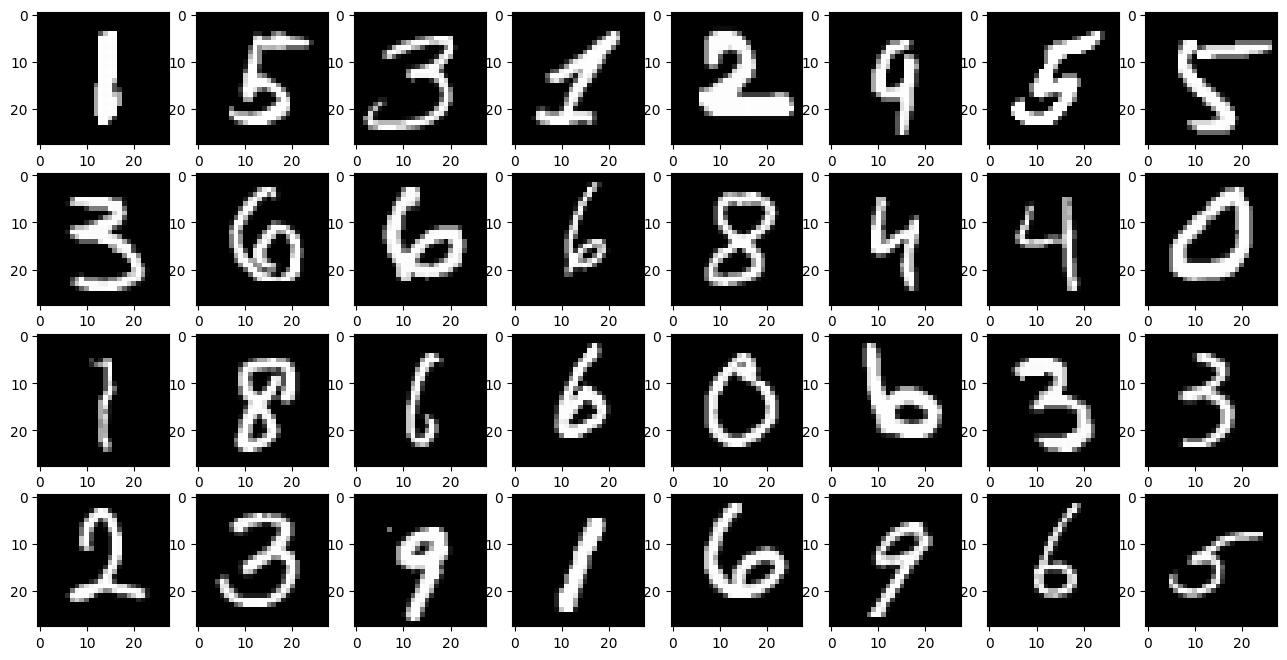

In [59]:
# it is likely that the plot this function will generate looks familiar to other plots you might have generated before
# or you might have encountered in other tutorials. So far, we aren't doing anything new, Federated Learning will start soon!
visualise_n_random_examples(mnist["train"], n=32)

# A CNN architecture

This tutorial is not so much about novel architectural designs so we keep things simple and make use of a typical CNN that is adequate for the MNIST image classification task.



In [60]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, num_classes: int) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Similarly to what we did with the dataset you could inspect the model in various ways. We can, for instance, count the number of model parameters.

In [61]:
model = Net(num_classes=10)
num_parameters = sum(value.numel() for value in model.state_dict().values())
print(f"{num_parameters = }")

num_parameters = 44426


## The Training Loop

A minimal training loop in PyTorch can be constructed with three functions:
*  `train()` that will train the model given a dataloader.
* `test()` that will be used to evaluate the performance of the model on held-out data, e.g., a training set.
* `run_centralised()` which will define additional elements (e.g. the optimiser) and run the training loop over N epochs.

Let's construct these functions!


In [62]:
def train_fn(net, trainloader, optimizer, device="cpu"):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    net.to(device)
    net.train()
    loss_accum = 0.0
    for batch in trainloader:
        images, labels = batch["image"].to(device), batch["label"].to(device)
        optimizer.zero_grad()
        loss = criterion(net(images), labels)
        loss.backward()
        optimizer.step()
        loss_accum += loss.item()
    return loss_accum / len(trainloader)


def test_fn(net, testloader, device):
    """Validate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, loss = 0, 0.0
    net.to(device)
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["image"].to(device), batch["label"].to(device)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    accuracy = correct / len(testloader.dataset)
    return loss, accuracy


def run_centralised(
    trainloader, testloader, epochs: int, lr: float, momentum: float = 0.9
):
    """A minimal (but complete) training loop"""

    # instantiate the model
    model = Net(num_classes=10)

    # Discover device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # define optimiser with hyperparameters supplied
    optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    # train for the specified number of epochs
    for e in range(epochs):
        print(f"Training epoch {e} ...")
        train_fn(model, trainloader, optim, device)

    # training is completed, then evaluate model on the test set
    loss, accuracy = test_fn(model, testloader, device)
    print(f"{loss = }")
    print(f"{accuracy = }")

Let's run this for 5 epochs (you'll see it reaching close to 99% accuracy -- as expected from a centralised setup with the MNIST dataset)

In [63]:
# Construct dataloaders
trainloader, testloader = get_mnist_dataloaders(mnist, batch_size=32)

# Run the centralised training
run_centralised(trainloader, testloader, epochs=3, lr=0.01)

Training epoch 0 ...
Training epoch 1 ...
Training epoch 2 ...
loss = 15.285170470175217
accuracy = 0.984


The above centralised formulation has worked just fine for some applications and to showcase the potential of AI in a variety of scenarios. However, as was discussed earlier in the session, centralised training is unsuitable for a larger range of settings were information cannot be collected in order to build a unified (centralised) dataset.

# The Future of AI is Federated

What are the key differences between Federated Learning and Centralised Training? I you could only pick you, probably you'd say:
* Federated Learning is distributed -- the model is trained on-device by the participating clients.
* Data remains private and is owned by a specific _client_ -- the data is never sent to the central server.

The are several more differences. But the above two are the main ones to always consider and that are common to all flavours of Federated Learning (e.g. _cross-device_ or _cross-silo_). The remaining of this tutorial is going to focus in transforming the code we have written so far for the centralised setting and construct a Federated Learning pipeline using Flower and PyTorch.

Let's begin! 🚀

## One Client, One Data Partition

To start designing a Federated Learning pipeline we need to meet one of the key properties in FL: each client has its own data partition. To accomplish this with the MNIST dataset, we are going to generate N random partitions, where N is the total number of clients in our FL system, using [Flower Datasets](https://flower.ai/docs/datasets/). Let's create 100 partitions with the [IidPartitioner](https://flower.ai/docs/datasets/ref-api/flwr_datasets.partitioner.IidPartitioner.html#flwr_datasets.partitioner.IidPartitioner) -- note there are many more [partitioners](https://flower.ai/docs/datasets/ref-api/flwr_datasets.partitioner.html) to choose from.

In [78]:
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner

NUM_PARTITIONS = 100

partitioner = IidPartitioner(num_partitions=NUM_PARTITIONS)
# Let's partition the "train" split of the MNIST dataset
# The MNIST dataset will be downloaded if it hasn't been already
fds = FederatedDataset(dataset="ylecun/mnist", partitioners={"train": partitioner})

Accessing individual partitions can be done like this. The return object can be then passed to a dataloader for training or evaluation.

In [65]:
# We could load a single partition like this
partition_0 = fds.load_partition(0)
partition_0

Dataset({
    features: ['image', 'label'],
    num_rows: 600
})

`Flower Datasets` comes with built-in visualization tools that help you get insights of how the dataset (in this case MNIST) has been partitioned. Let's create a parplot to visualize the number of labels of each class that every client's partition contains. Note we are only visualising the first 30 clients purely so the plot remain readable. 

> There are many more types of plots you can generated with Flower Datasets. Check the [Visualization tutorial](https://flower.ai/docs/datasets/tutorial-visualize-label-distribution.html). Feel free to try other partitioning scheemes and you'll see how the visualization changes.

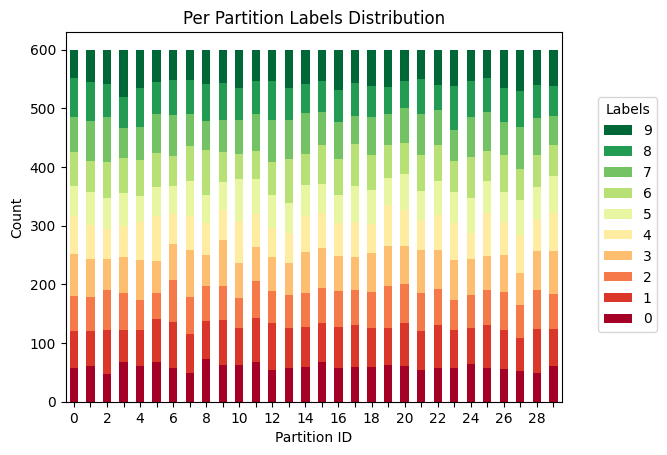

In [66]:
from flwr_datasets.visualization import plot_label_distributions

fig, ax, df = plot_label_distributions(
    partitioner,
    label_name="label",
    plot_type="bar",
    size_unit="absolute",
    partition_id_axis="x",
    legend=True,
    verbose_labels=True,
    max_num_partitions=30,  # Note we are only showing the first 30 so the plot remains readable
    title="Per Partition Labels Distribution",
)

As you can see, the histogram of this partition is a bit different from the one we obtained at the beginning where we took the entire dataset into consideration. Because our data partitions are artificially constructed by sampling the MNIST dataset in an IID fashion, our Federated Learning example will not face sever _data heterogeneity_ issues (which is a fairly [active research topic](https://arxiv.org/abs/1912.04977)).

## Constructing Messages

In Flower, the server and clients communicate by sending and receiving [Message](https://flower.ai/docs/framework/ref-api/flwr.app.Message.html#flwr.app.Message)
objects. A `Message` carries a [RecordDict](https://flower.ai/docs/framework/ref-api/flwr.app.RecordDict.html#flwr.app.RecordDict) as its main payload. The `RecordDict`
is like a Python dictionary that can contain multiple records of different types. There
are three main types of records:

- [ArrayRecord](https://flower.ai/docs/framework/ref-api/flwr.app.ArrayRecord.html): Contains model parameters as a dictionary of NumPy arrays
- [MetricRecord](https://flower.ai/docs/framework/ref-api/flwr.app.MetricRecord.html): Contains training or evaluation metrics as a dictionary of
  integers, floats, lists of integers, or lists of floats.
- [ConfigRecord](https://flower.ai/docs/framework/ref-api/flwr.app.ConfigRecord.html#flwr.app.ConfigRecord): Contains configuration parameters as a dictionary of integers,
  floats, strings, booleans, or bytes. Lists of these types are also supported.

Let's see a few examples of how to work with these types of records and, ultimately,
construct a `RecordDict` that can be sent over a `Message`.

In [67]:
from flwr.app import ArrayRecord, MetricRecord, ConfigRecord, RecordDict

# ConfigRecord can be used to communicate configs between ServerApp and ClientApp
# They can hold scalars, but also strings and booleans
config = ConfigRecord(
    {"batch_size": 32, "use_augmentation": True, "data-path": "/my/dataset"}
)

# MetricRecords expect scalar-based metrics (i.e. int/float/list[int]/list[float])
# By limiting the types Flower can aggregate MetricRecords automatically
metrics = MetricRecord({"accuracy": 0.9, "losses": [0.1, 0.001], "perplexity": 2.31})

# ArrayRecord objects are designed to communicate arrays/tensors/weights from ML models
model = Net(num_classes=10)
array_record = ArrayRecord(model.state_dict())  # for a PyTorch model
# Then you can conver the ArrayRecord back into a PyTorch state_dict with:
state_dict = array_record.to_torch_state_dict()

# A RecordDict is like a dictionary that holds named records.
# This is the main payload of a Message
rd = RecordDict({"my-config": config, "metrics": metrics, "my-model": array_record})

> Check the [ArrayRecord](https://flower.ai/docs/framework/ref-api/flwr.app.ArrayRecord.html#flwr.app.ArrayRecord) documentation to learn how to use models from other ML frameworks other than PyTorch.

Let's next define how our FL clients will behave

## Defining a Flower `ClientApp`


You can think of a client in FL as an entity that owns some data and trains a model using this data. The caveat is that the model is being trained _collaboratively_ in Federation by multiple clients (sometimes up to hundreds of thousands) and, in most instances of FL, is sent by a central server running in a `ServerApp` (more on this later).

We can define how the `ClientApp` performs training by wrapping a function with the
`@app.train()` decorator. In this case we name this function `train` because we'll
use it to train the model on the local data. The function always expects two arguments:

- A [Message](https://flower.ai/docs/framework/ref-api/flwr.app.Message.html#flwr.app.Message): The message received from the server. It contains the model
  parameters and any other configuration information sent by the server.
- A [Context](https://flower.ai/docs/framework/ref-api/flwr.app.Context.html#flwr.app.Context): The context object that contains information about the node
  executing the `ClientApp` and about the current run. 

> **Note**: When running Flower on a notebook, the `run_config` in the `Context` is always empty. It's is recommended to run Flower on the terminal via `flwr run` instead of in a notebook/colab. Check the [Flower Tutorial](https://flower.ai/docs/framework/tutorial-series-get-started-with-flower-pytorch.html) to learn more.

In Flower, `ClientApps` are
ephemeral objects that get instantiated for the execution of one `Message` and
destroyed when a reply is communicated back to the server.

Let's see an implementation of `ClientApp` that uses the previously defined PyTorch
CNN model, applies the parameters received from the `ServerApp` via the message, loads
its local data, trains the model with it (using the `train_fn` function), and
generates a reply `Message` containing the updated model parameters as well as some
metrics of interest.

Now let's define our Flower Client class:

In [68]:
from flwr.app import Context, Message
from flwr.clientapp import ClientApp

# Flower ClientApp
client_app = ClientApp()


@client_app.train()
def train(msg: Message, context: Context):
    """Train the model on local data."""

    # Load the model and initialize it with the received weights
    model = Net(num_classes=10)
    model.load_state_dict(msg.content["arrays"].to_torch_state_dict())
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Load the data
    partition_id = context.node_config["partition-id"]
    partition = fds.load_partition(partition_id, "train")
    # partition into train/validation
    partition_train_val = partition.train_test_split(test_size=0.1, seed=42)

    # Let's use the function defined earlier to construct the dataloaders
    # and apply the dataset transformations
    trainloader, _ = get_mnist_dataloaders(partition_train_val, batch_size=32)

    # Let's defined the optimizer
    lr = msg.content["config"]["lr"]
    optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    # Call the training function
    train_loss = train_fn(
        model,
        trainloader,
        optim,
        device,
    )

    # Construct and return reply Message
    model_record = ArrayRecord(model.state_dict())
    metrics = {
        "train_loss": train_loss,
        "num-examples": len(trainloader.dataset),
    }
    metric_record = MetricRecord(metrics)
    content = RecordDict({"arrays": model_record, "metrics": metric_record})
    return Message(content=content, reply_to=msg)

In a typical federated learning setup, the ``ClientApp`` would also implement an
``@app.evaluate()`` function to evaluate the model received from the ``ServerApp`` on
local validation data. This is especially useful to monitor the performance of the
global model on each client during training. The implementation of the ``evaluate``
function is very similar to the ``train`` function, except that it calls the ``test_fn``
function defined earlier in this tutorial (which implements the PyTorch evaluation loop)
and it returns a ``Message`` containing only a ``MetricRecord`` with the evaluation
metrics (no ``ArrayRecord`` because the model parameters are not updated during
evaluation). Here's how the ``evaluate`` function looks like:

In [69]:
@client_app.evaluate()
def evaluate(msg: Message, context: Context):
    """Evaluate the model on local data."""

    # Load the model and initialize it with the received weights
    model = Net(num_classes=10)
    model.load_state_dict(msg.content["arrays"].to_torch_state_dict())
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Load the data
    partition_id = context.node_config["partition-id"]
    partition = fds.load_partition(partition_id, "train")
    # partition into train/validation
    partition_train_val = partition.train_test_split(test_size=0.1, seed=42)

    # Let's use the function defined earlier to construct the dataloaders
    # and apply the dataset transformations. Let's use the validation set here
    _, valloader = get_mnist_dataloaders(partition_train_val, batch_size=32)

    # Call the evaluation function
    eval_loss, eval_acc = test_fn(
        model,
        valloader,
        device,
    )

    # Construct and return reply Message
    metrics = {
        "eval_loss": eval_loss,
        "eval_acc": eval_acc,
        "num-examples": len(valloader.dataset),
    }
    metric_record = MetricRecord(metrics)
    content = RecordDict({"metrics": metric_record})
    return Message(content=content, reply_to=msg)

As you can see the `evaluate` implementation is near identical to the `train`
implementation, except that it calls the `test_fn` function instead of the
`train_fn` function and it returns a `Message` containing only a `MetricRecord`
with metrics relevant to evaluation (`eval_loss`, `eval_acc` -- both scalars). We
also need to include the `num-examples` key in the metrics so the server can aggregate
the evaluation metrics correctly.

Now that a `ClientApp` is fully defined, let's create its counterpart: the `ServerApp`.

## Defining a Flower `ServerApp`

On the server side, we need to configure a strategy which encapsulates the federated
learning approach/algorithm, for example, *Federated Averaging* (FedAvg). Flower has a
number of [built-in strategies](https://flower.ai/docs/framework/ref-api/flwr.serverapp.strategy.html#module-flwr.serverapp.strategy), but we can also use our own strategy implementations to
customize nearly all aspects of the federated learning approach. For this tutorial, we
use the built-in [FedAvg](https://flower.ai/docs/framework/ref-api/flwr.serverapp.strategy.FedAvg.html#flwr.serverapp.strategy.FedAvg) implementation and customize it slightly by specifying the
fraction of connected nodes to involve in a round of training.

To construct a |serverapp_link|_, we define its `@app.main()` method. This method
receives as input arguments:

- a `Grid` object that will be used to interface with the nodes running the
  `ClientApp` to involve them in a round of train/evaluate/query or other.
- a `Context` object that provides access to the run configuration.

> Recall that, just like for the `ClientApp` the run config is empty when running Flower without `flwr run`.

Before launching the strategy via the [start()](https://flower.ai/docs/framework/ref-api/flwr.serverapp.strategy.Strategy.html#flwr.serverapp.strategy.Strategy.start) method, we want to
initialize the global model. This will be the model that gets sent to the `ClientApp`
running on the clients in the first round of federated learning. We can do this by
creating an instance of the model (`Net`), extracting the parameters in its
`state_dict`, and constructing an `ArrayRecord` with them. We can then make it
available to the strategy via the `initial_arrays` argument of the `start()` method.

We can also optionally pass to the `start()` method a `ConfigRecord` containing
settings that we would like to communicate to the clients. These will be sent as part of
the `Message` that also carries the model parameters.

In [70]:
from flwr.app import Context
from flwr.serverapp import Grid, ServerApp
from flwr.serverapp.strategy import FedAvg

server_app = ServerApp()


@server_app.main()
def main(grid: Grid, context: Context) -> None:
    """Main entry point for the ServerApp."""

    # Load global model
    global_model = Net(num_classes=10)
    arrays = ArrayRecord(global_model.state_dict())

    # Initialize FedAvg strategy
    # Sample half of the clients for federated training and
    # all of the clients for federated evaluation
    strategy = FedAvg(fraction_train=0.5, fraction_evaluate=1.0)

    # Start strategy, run FedAvg for `num_rounds`
    # We define a `ConfigRecord` with a learning rate of 0.1
    # This will be sent to all clients at the beginning of each round of training
    result = strategy.start(
        grid=grid,
        initial_arrays=arrays,
        train_config=ConfigRecord({"lr": 0.1}),
        num_rounds=5,
    )

    # Save final model to disk
    print("\nSaving final model to disk...")
    state_dict = result.arrays.to_torch_state_dict()
    torch.save(state_dict, "final_model.pt")

After the execution of the `start()` method, the `ServerApp` will save the state_dict of the resulting model to disk.

## Launching the Simulation

With both `ClientApp` and `ServerApp` ready, we can launch the simulation. Pass both apps to the `run_simulation()` function and specify the number of `supernodes` (this is a more general term used in Flower to refer to individual "nodes" or "clients"). We earlier partitioned the dataset into 100 partitions, one for each supernode. So we indicate that `num_supernodes`=100.

In [71]:
from flwr.simulation import run_simulation

run_simulation(
    server_app=server_app, client_app=client_app, num_supernodes=NUM_PARTITIONS
)

INFO :      Starting FedAvg strategy:
INFO :      	├── Number of rounds: 5
INFO :      	├── ArrayRecord (0.17 MB)
INFO :      	├── ConfigRecord (train): {'lr': 0.1}
INFO :      	├── ConfigRecord (evaluate): (empty!)
INFO :      	├──> Sampling:
INFO :      	│	├──Fraction: train (0.50) | evaluate ( 1.00)
INFO :      	│	├──Minimum nodes: train (2) | evaluate (2)
INFO :      	│	└──Minimum available nodes: 2
INFO :      	└──> Keys in records:
INFO :      		├── Weighted by: 'num-examples'
INFO :      		├── ArrayRecord key: 'arrays'
INFO :      		└── ConfigRecord key: 'config'
INFO :      
INFO :      
INFO :      [ROUND 1/5]
INFO :      configure_train: Sampled 50 nodes (out of 100)
INFO :      aggregate_train: Received 50 results and 0 failures
INFO :      	└──> Aggregated MetricRecord: {'train_loss': 2.2745758642869838}
INFO :      configure_evaluate: Sampled 100 nodes (out of 100)
INFO :      aggregate_evaluate: Received 100 results and 0 failures
INFO :      	└──> Aggregated MetricRecord


Saving final model to disk...


## Bonus: Create your own Strategy

> Find an extended version of this tutorial in the [how-to use a Flower Strategy](https://flower.ai/docs/framework/tutorial-series-use-a-federated-learning-strategy-pytorch.html) page.

Flower strategies can be extended easily to suit your FL setups or your preferred workflows whether you use Flower for research or in production. In this final section, you'll learn how to create a custom strategy that behaves just like `FedAvg` but extends the functionality to facilitate LR schedulling. Then, the `ServerApp` will make a plot once the execution of the `start()` method.

Let's call this strategy `FedAvgCustom`. We'll use it to also showcase how to use the `evaluate_fn` callback, a convenient way to do centralised evaluation of the global model after each round. Note this functionality is user-defined since it requires a choice in terms of ML-framework. (if you recall, Flower is framework agnostic).

> This being said, centralised evaluation of the global model is only possible if there exists a centralised dataset that somewhat follows a similar distribution as the data that's spread across clients. In some cases having such centralised dataset for validation is not possible, so the only solution is to federate the evaluation of the _global model_. This is the default behaviour in Flower. If you don't specify the `evaluate_fn` argument in your strategy, then, centralised global evaluation won't be performed.

The `FedAvgCustom` defined below only modifies the `configure_train` method of the `FedAvg` strategy. This method is used to prepare the messages that are going to be sent to the `ClientApps`. These messages contain to main payloads: an `ArrayRecord` representing the model to federate; and a `ConfigRecord` containing settings/configs relevant for the `ClientApps` participanting in the given round. Below, we simply apply learning rate decay every 5 rounds by halving the LR found in the config record.

In [72]:
from typing import Iterable
from flwr.serverapp import Grid
from flwr.serverapp.strategy import FedAvg
from flwr.app import ArrayRecord, ConfigRecord, Message


class FedAvgCustom(FedAvg):
    def configure_train(
        self, server_round: int, arrays: ArrayRecord, config: ConfigRecord, grid: Grid
    ) -> Iterable[Message]:
        """Configure the next round of federated training and maybe do LR decay."""
        # Decrease learning rate by a factor of 0.5 every 5 rounds
        if server_round % 5 == 0 and server_round > 0:
            config["lr"] *= 0.5
            print("LR decreased to:", config["lr"])
        # Pass the updated config and the rest of arguments to the parent class
        return super().configure_train(server_round, arrays, config, grid)

We’ve seen how federated evaluation works on the client side (i.e., by implementing a function wrapped with the @app.evaluate decorator in your `ClientApp`). Now let’s see how we can evaluate the aggregated model parameters on the server side.

To do so, we need to create a new function that we can name `central_evaluate`. This function is a callback that will be passed to the start method of our strategy. This means that the strategy will call this function after every round of federated learning passing two arguments: the current round of federated learning and the aggregated model parameters.

In [ ]:
def central_evaluate(server_round: int, arrays: ArrayRecord) -> MetricRecord:
    """Evaluate model on the server side."""

    # Load the model and initialize it with the received weights
    model = Net(num_classes=10)
    model.load_state_dict(arrays.to_torch_state_dict())
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # We use the testloader defined earlier in the centralized section
    # Evaluate the model on the test set
    loss, accuracy = test_fn(model, testloader, device)

    # Return the evaluation metrics
    return MetricRecord({"accuracy": accuracy, "loss": loss})

With the above defined, we just need to wrap it all up in a `ServerApp` as we did earlier but this time using the `FedAvgCustom` that we just defined. We'll run the strategy for 10 rounds so to observe the effect of LR decay.

Remember we mentioned this `central_evaluate` will be called by the strategy. To do so we need to pass it to the strategy’s start method as shown below.

In [85]:
@server_app.main()
def main(grid: Grid, context: Context) -> None:
    """Main entry point for the ServerApp."""

    # Load global model
    global_model = Net(num_classes=10)
    arrays = ArrayRecord(global_model.state_dict())

    # Initialize FedAvgCustom strategy
    strategy = FedAvgCustom(fraction_train=0.5, fraction_evaluate=1.0)

    # Start strategy
    result = strategy.start(
        grid=grid,
        initial_arrays=arrays,
        train_config=ConfigRecord({"lr": 0.1}),
        num_rounds=10,
        evaluate_fn=central_evaluate,  # <--- here we pass the evaluate function
    )

    # Save final model to disk
    print("\nSaving final model to disk...")
    state_dict = result.arrays.to_torch_state_dict()
    torch.save(state_dict, "final_model.pt")

    # let's make a plot of the accuracy obtained after each round
    # Note here we use the keys in central_evaluate
    central_acc = [
        rnd["accuracy"] for rnd in result.evaluate_metrics_serverapp.values()
    ]

    plt.plot(central_acc, label="Accuracy")
    plt.xlabel("Round")
    plt.ylabel("Metric")
    plt.legend()
    plt.show()

All that is left is to launch the simulation. You will note the following three differences compared to the previous run:

- The global model is evaluated before round 1 and then after each round.
- The learning rate is decreased by 50% at round 5
- A line plot is generated at the end of the run.

INFO :      Starting FedAvgCustom strategy:
INFO :      	├── Number of rounds: 10
INFO :      	├── ArrayRecord (0.17 MB)
INFO :      	├── ConfigRecord (train): {'lr': 0.1}
INFO :      	├── ConfigRecord (evaluate): (empty!)
INFO :      	├──> Sampling:
INFO :      	│	├──Fraction: train (0.50) | evaluate ( 1.00)
INFO :      	│	├──Minimum nodes: train (2) | evaluate (2)
INFO :      	│	└──Minimum available nodes: 2
INFO :      	└──> Keys in records:
INFO :      		├── Weighted by: 'num-examples'
INFO :      		├── ArrayRecord key: 'arrays'
INFO :      		└── ConfigRecord key: 'config'
INFO :      
INFO :      Initial global evaluation results: {'accuracy': 0.0892, 'loss': 722.123051404953}
INFO :      
INFO :      [ROUND 1/10]
INFO :      configure_train: Sampled 50 nodes (out of 100)
INFO :      aggregate_train: Received 50 results and 0 failures
INFO :      	└──> Aggregated MetricRecord: {'train_loss': 2.232874622064478}
INFO :      configure_evaluate: Sampled 100 nodes (out of 100)
INFO :  

LR decreased to: 0.05


INFO :      aggregate_train: Received 50 results and 0 failures
INFO :      	└──> Aggregated MetricRecord: {'train_loss': 0.7902660509856305}
INFO :      configure_evaluate: Sampled 100 nodes (out of 100)
INFO :      aggregate_evaluate: Received 100 results and 0 failures
INFO :      	└──> Aggregated MetricRecord: {'eval_loss': 0.7659968465566634, 'eval_acc': 0.887166666666667}
INFO :      Global evaluation
INFO :      	└──> MetricRecord: {'accuracy': 0.9005, 'loss': 106.98260290548205}
INFO :      
INFO :      [ROUND 6/10]
INFO :      configure_train: Sampled 50 nodes (out of 100)
INFO :      aggregate_train: Received 50 results and 0 failures
INFO :      	└──> Aggregated MetricRecord: {'train_loss': 0.39414296558674644}
INFO :      configure_evaluate: Sampled 100 nodes (out of 100)
INFO :      aggregate_evaluate: Received 100 results and 0 failures
INFO :      	└──> Aggregated MetricRecord: {'eval_loss': 0.5308277768827975, 'eval_acc': 0.9208333333333331}
INFO :      Global evaluatio

LR decreased to: 0.025


INFO :      aggregate_train: Received 50 results and 0 failures
INFO :      	└──> Aggregated MetricRecord: {'train_loss': 0.178825867517906}
INFO :      configure_evaluate: Sampled 100 nodes (out of 100)
INFO :      aggregate_evaluate: Received 100 results and 0 failures
INFO :      	└──> Aggregated MetricRecord: {'eval_loss': 0.3214560594968498, 'eval_acc': 0.9521666666666664}
INFO :      Global evaluation
INFO :      	└──> MetricRecord: {'accuracy': 0.9577, 'loss': 41.54895875870716}
INFO :      
INFO :      Strategy execution finished in 163.55s
INFO :      
INFO :      Final results:
INFO :      
INFO :      	Global Arrays:
INFO :      		ArrayRecord (0.171 MB)
INFO :      	
INFO :      	Aggregated ClientApp-side Train Metrics:
INFO :      	{ 1: {'train_loss': '2.2329e+00'},
INFO :      	  2: {'train_loss': '1.8810e+00'},
INFO :      	  3: {'train_loss': '1.7013e+00'},
INFO :      	  4: {'train_loss': '1.2070e+00'},
INFO :      	  5: {'train_loss': '7.9027e-01'},
INFO :      	  6: {


Saving final model to disk...


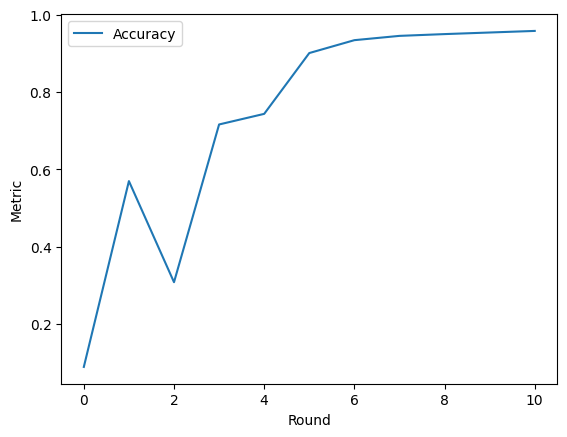

In [86]:
run_simulation(
    server_app=server_app, client_app=client_app, num_supernodes=NUM_PARTITIONS
)

## What's next?

Well, if you enjoyed this content, consider giving us a ⭐️ on GitHub -> https://github.com/adap/flower

* **[TUTORIAL]:** : Check the `Flower Tutorial` for a more [step-by-step and comprenhensive](https://flower.ai/docs/framework/tutorial-series-get-started-with-flower-pytorch.html) learning experience. How about running your Flower clients on the GPU? find out how to do it in the [Flower Simulation Documentation](https://flower.ai/docs/framework/how-to-run-simulations.html)

* Check the quickstart tutorials in https://flower.ai/docs/framework/, for example:
    * [Quickstart PyTorch](https://flower.ai/docs/framework/tutorial-quickstart-pytorch.html)
    * [Quickstart TensorFlow](https://flower.ai/docs/framework/tutorial-quickstart-tensorflow.html)
    * [Quickstart JAX](https://flower.ai/docs/framework/tutorial-quickstart-jax.html)

* Most examples in the Flower Flower GitHub can run in simulation. These are some:

    * [Advanced PyTorch](https://github.com/adap/flower/tree/main/examples/advanced-pytorch)
    * [Finetuning a ViT](https://github.com/adap/flower/tree/main/examples/flowertune-vit)
    * [Quickstart with 🤗 Huggingface](https://github.com/adap/flower/tree/main/examples/quickstart-huggingface)
    * [Quickstart with XGBoost](https://github.com/adap/flower/tree/main/examples/xgboost-quickstart)
    * [Quickstart with MLX](https://github.com/adap/flower/tree/main/examples/quickstart-mlx)


* **[DOCS]** All Flower examples: https://flower.ai/docs/examples/

* **[VIDEO]** Our Youtube channel: https://www.youtube.com/@flowerlabs

Don't forget to join our Slack channel: https://flower.ai/join-slack/
